In [190]:
import pandas as pd

prot_df = pd.read_csv('data/train_proteins.csv')
clin_df = pd.read_csv('data/train_clinical_data.csv')
clin_df = clin_df.rename(columns={'upd23b_clinical_state_on_medication': 'on_meds'})

clin_df['on_meds'] = clin_df['on_meds'].fillna(0)
clin_df['on_meds'] = clin_df['on_meds'].replace({'Off': 0, 'On': 1})


In [191]:
pivoted = prot_df.pivot(index="visit_id", columns="UniProt", values="NPX")

import numpy as np

# Normalize each column separately
for col in pivoted.columns:
    col_data = pivoted[col].dropna()
    mean = col_data.mean()
    std = col_data.std(ddof=1)
    pivoted[col] = (pivoted[col] - mean) / std
    
# Replace original NaN values in pivoted with 0
# norm_prot_df = pivoted.fillna(0)


In [192]:
# Calculate mean and standard deviation of updrs_1 through updrs_4
updrs_mean = clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].mean()
updrs_std = clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].std()


# Normalize updrs_1 through updrs_4 and round to 3 sig figs
clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']] = ((clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']] - updrs_mean) / updrs_std).round(3)



In [193]:

import pandas as pd

#merge UPDRS and Protein values
merged_norm_df = pd.merge(norm_clin_df, norm_prot_df, on='visit_id')
merged_df = pd.merge(clin_df, pivoted, on='visit_id')

In [197]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Select the columns of interest
protein_columns = merged_df_no_nan_numeric.iloc[:, 8:]
updrs_columns = merged_df_no_nan_numeric[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]

# Create an empty DataFrame to store the results
updrs_df = pd.DataFrame()

# Fit a multivariate linear regression model for each updrs separately
for updrs_col in updrs_columns:
    regressor = LinearRegression()
    regressor.fit(protein_columns, merged_df_no_nan_numeric[updrs_col])

    # Predict updrs values using the protein columns and round to nearest whole number
    updrs_predictions = regressor.predict(protein_columns)
    updrs_predictions = np.clip(updrs_predictions, a_min=0, a_max=None)
    updrs_predictions = np.round(updrs_predictions)

    # Add the predicted and actual updrs values to the DataFrame
    updrs_predictions_df = pd.DataFrame(updrs_predictions, columns=[f'{updrs_col}_pred'])
    updrs_actual_df = merged_df_no_nan_numeric[[updrs_col]]
    updrs_df = pd.concat([updrs_df, updrs_predictions_df, updrs_actual_df], axis=1)

    # Calculate MSE and other error types
    mse = mean_squared_error(updrs_actual_df, updrs_predictions_df)
    r2 = r2_score(updrs_actual_df, updrs_predictions_df)
    mae = mean_absolute_error(updrs_actual_df, updrs_predictions_df)

    # Print the error types for the current updrs column
    print(f"Error types for {updrs_col}:")
    print("MSE:", round(mse,2))
    print("R2:", round(r2,2))
    print("MAE:", round(mae,2))

# Print the first few rows of the DataFrame
print(updrs_df.head())


Error types for updrs_1:
MSE: 17.19
R2: 0.39
MAE: 3.19
Error types for updrs_2:
MSE: 19.37
R2: 0.45
MAE: 3.37
Error types for updrs_3:
MSE: 120.79
R2: 0.47
MAE: 8.77
Error types for updrs_4:
MSE: 3.44
R2: 0.42
MAE: 1.16
   updrs_1_pred  updrs_1  updrs_2_pred  updrs_2  updrs_3_pred  updrs_3   
0           7.0     10.0           3.0      6.0          10.0     15.0  \
1           7.0      8.0           9.0     10.0          27.0     34.0   
2           6.0     10.0           4.0     10.0          21.0     41.0   
3          14.0     17.0          14.0     18.0          36.0     51.0   
4           5.0      8.0           6.0      2.0          23.0     21.0   

   updrs_4_pred  updrs_4  
0           0.0      0.0  
1           1.0      0.0  
2           1.0      0.0  
3           2.0      0.0  
4           1.0      0.0  


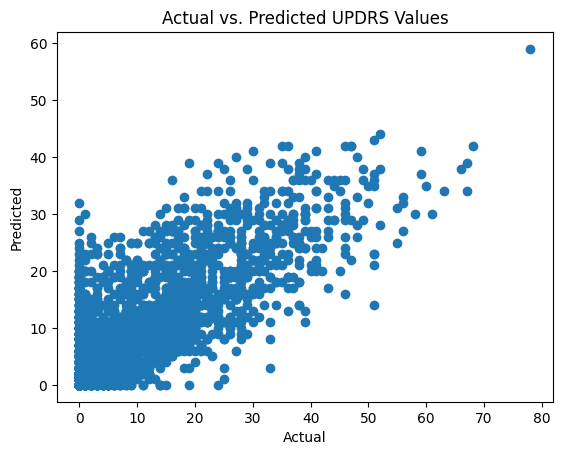

In [195]:
import matplotlib.pyplot as plt

# Select the actual and predicted values
actual = updrs_actual_df.values.flatten()
predicted = updrs_predictions_df.values.flatten()

# Plot the actual vs. predicted values
plt.scatter(actual, predicted)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted UPDRS Values')
plt.show()


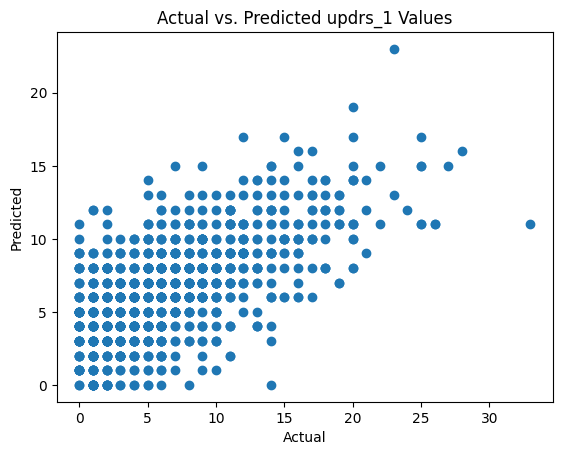

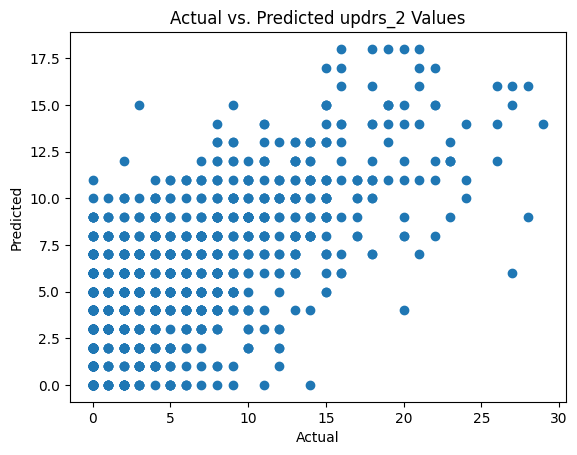

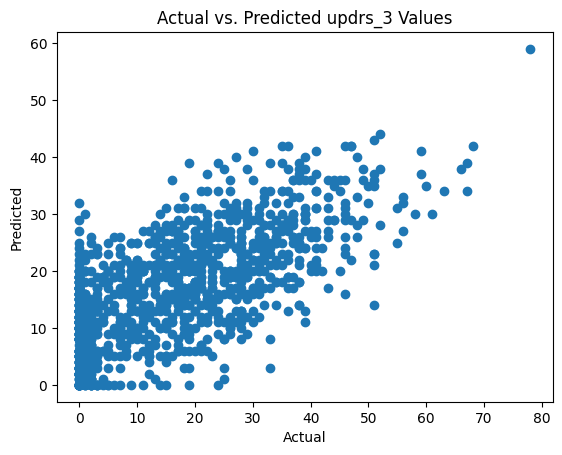

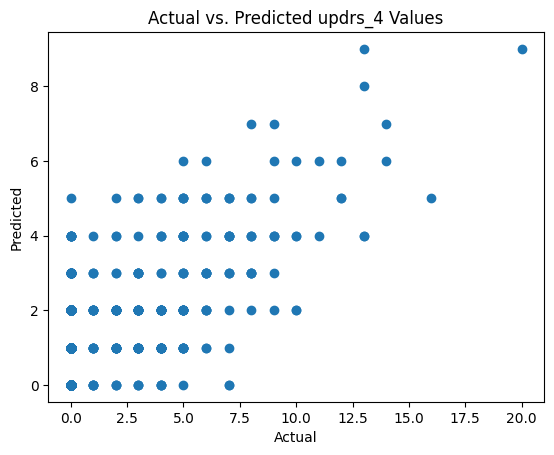

In [184]:
import matplotlib.pyplot as plt

# Loop over the columns in the updrs_df DataFrame
for col in updrs_df.columns:
    if 'pred' in col:
        # Get the corresponding actual column name
        actual_col = col.replace('_pred', '')
        
        # Select the actual and predicted values
        actual = updrs_df[actual_col].values
        predicted = updrs_df[col].values
        
        # Plot the actual vs. predicted values
        plt.scatter(actual, predicted)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs. Predicted {actual_col} Values')
        plt.show()
